# Fine tuning test
Test the possibility to manually annotated a few frames of the experiment, then fine tune the network on them to predict the rest of the frames.  
This is kind of overfitting part of the test set to perform well on the rest, or domain adaptation.

In [1]:
%matplotlib inline

import os, sys, time, shutil, copy, time
import random
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
from scipy import ndimage as ndi
import cv2
import imgaug.augmenters as iaa

import torch

from utils_common.image import imread_to_float, to_npint, overlay_preds_targets
from utils_common.metrics import dice_coef
from utils_data import normalize_range, get_all_dataloaders, pad_transform, pad_transform_stack, compute_weights
from utils_finetuning import fine_tune, ROISelector
from utils_loss import get_BCEWithLogits_loss
from utils_metric import get_dice_metric
from utils_model import CustomUNet, load_model
from utils_test import predict, predict_stack, evaluate, evaluate_stack

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


### Parameters

In [2]:
batch_size = 16
learning_rate = 0.0005

# Choose wether or not use synth, aug, and weights for fine tuning
synth_data = False
synth_ratio = None # ratio of synthetic data vs. real data
only_synth = False # If True, will use only the synthetic data (and all of it, at the opposite of ratio=1)
data_aug = False # If True, will use data augmentation (see below for augmentation sequence)
use_weights = True # if False use class weights, if True use pixelwise weights (if existing)

input_channels = "RG" # Channel to use as input
u_depth = 4
out1_channels = 16

out_model_name = "models/test_ft"
model_name = "models/unet4-16_RG_cv-annotated/"
data_dir = "/data/talabot/pdm/dataset_cv-annotated/"

### Prepare training
Make dataloaders and so on to prepare fine tuning training

### Load model

In [48]:
# model = CustomUNet(in_channels=len(input_channels), u_depth=u_depth, 
#                    out1_channels=out1_channels, device=device)
model = load_model(model_name, input_channels=input_channels, u_depth=u_depth, 
                   out1_channels=out1_channels, device=device)

# loss_fn = get_BCEWithLogits_loss(pos_weight=pos_weight, neg_weight=neg_weight)
metrics = {"dice": get_dice_metric()}

# Save future model
os.makedirs(out_model_name, exist_ok=True)
shutil.copy("utils_model.py", os.path.join(out_model_name, "utils_model_save.py"))

'models/test_ft/utils_model_save.py'

## Load experiments and annotated frames
Load an experiment, predict once the detections, and create annotations for a few frames.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

experiment = "/data/talabot/experiments/annotated/R70H06_20181202-tdTomGC6fopt-fl2/R70H06-tdTomGC6fopt-fly2-001/"
# Load experiment and segmentation & weights if available
rgb_stack = imread_to_float(os.path.join(experiment, "RGB.tif"))
if os.path.isfile(os.path.join(experiment, "seg_ROI.tif")):
    seg_stack = imread_to_float(os.path.join(experiment, "seg_ROI.tif"))
else:
    seg_stack = None
if use_weights and os.path.isfile(os.path.join(experiment, "weights.tif")):
    weights_stack = imread_to_float(os.path.join(experiment, "weights.tif"))
else:
    weights_stack = None

# Predict using loaded model
start = time.time()
predictions = predict_stack(model, rgb_stack, batch_size, input_channels=input_channels,
                            transform=lambda stack: normalize_range(pad_transform_stack(stack, u_depth)))
predictions = torch.sigmoid(predictions)
print("Predicted experiment in %.1f s." % (time.time() - start))

if seg_stack is not None:
    print("Dice =", dice_coef((predictions > 0.5).numpy(), seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:
        plt.subplot(232)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    if weights_stack is not None:
        plt.subplot(233)
        plt.title("Pixel weighting")
        plt.imshow(weights_stack[image], cmap="gray")
    plt.subplot(235)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    if seg_stack is not None:
        plt.subplot(236)
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets((predictions[image] > 0.5).numpy(), seg_stack[image]))
    plt.tight_layout()
    plt.show()

Predicted experiment in 2.2 s.
Dice = 0.19969367975092164


interactive(children=(IntSlider(value=0, description='image', max=567), Output()), _dom_classes=('widget-inter…

Use the ground truth as annotations to test how many frames are needed, and how to fine tune.

OR Make manual annotations.

Indices of annotated frames:
[460 554  87 371]


<IPython.core.display.Javascript object>


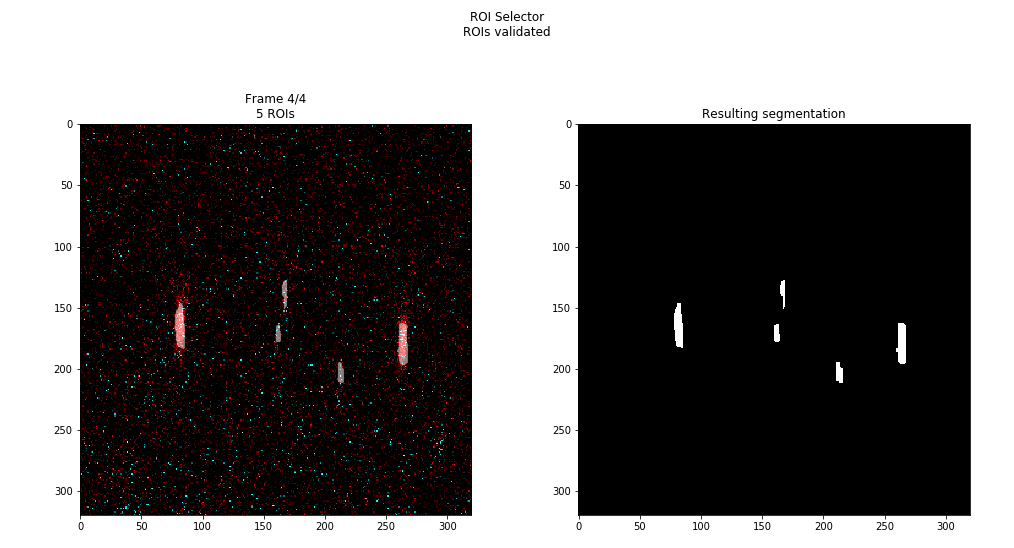

In [51]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Select and annotated frames
n_annotations = 4 # number of frames to annotated
n_valid = 1 # number of annotated frames to use for validation

# Randomly choose frames
indices_annotated = np.random.choice(np.arange(len(rgb_stack)), size=n_annotations, replace=False)
print("Indices of annotated frames:", indices_annotated, sep="\n")
rgb_annotated = np.stack([rgb_stack[idx] for idx in indices_annotated])

# Take ground truths as annotation
roi_selector = ROISelector(rgb_annotated)
seg_annotated = roi_selector.segmentation

Indices of annotated frames:
[502 560 401 434 460]


<IPython.core.display.Javascript object>


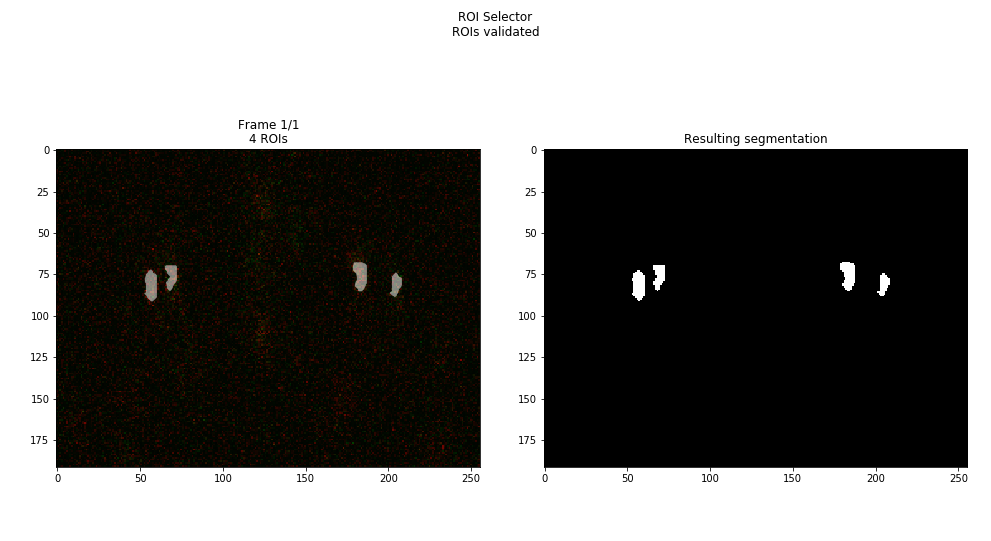

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Manually add indices for annotation if annotation was not good enough
new_idx = []

# Randomly choose frames
print("Indices of annotated frames:", np.concatenate([indices_annotated, new_idx]), sep="\n")
new_rgb_annotated = np.stack([rgb_stack[idx] for idx in new_idx])

# Take ground truths as annotation
new_roi_selector = ROISelector(new_rgb_annotated)
new_seg_annotated = new_roi_selector.segmentation

In [34]:
# Add new annotations for training
rgb_annotated = np.concatenate([new_rgb_annotated, rgb_annotated])
seg_annotated = np.concatenate([new_seg_annotated, seg_annotated])

In [55]:
seg_annotated = seg_annotated.astype(rgb_annotated.dtype)
# Create weights
if use_weights:
    weights_annotated = compute_weights(seg_annotated)
else:
    weights_annotated = None

model_ft = fine_tune(model, rgb_annotated, seg_annotated, weights=weights_annotated, 
                     n_iter=200, n_valid=1, batch_size=16, learning_rate = 0.0005, verbose=1)

Iteration (over 200): 
20: dice = 0.427612 - val_dice = 0.470372
40: dice = 0.555612 - val_dice = 0.611084
60: dice = 0.625717 - val_dice = 0.648178
80: dice = 0.660888 - val_dice = 0.660561
100: dice = 0.681400 - val_dice = 0.686073
120: dice = 0.727368 - val_dice = 0.698912
140: dice = 0.746907 - val_dice = 0.703863
160: dice = 0.786339 - val_dice = 0.696833
180: dice = 0.817066 - val_dice = 0.699867
200: dice = 0.840707 - val_dice = 0.695007
Best model fine tuned in iteration 105.


In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

# Predict again, and compare results
start = time.time()
predictions_ft = predict_stack(model_ft, rgb_stack, batch_size, input_channels=input_channels,
                               transform=lambda stack: normalize_range(pad_transform_stack(stack, u_depth)))
predictions_ft = torch.sigmoid(predictions_ft)
print("Predicted experiment in %.1f s." % (time.time() - start))

if seg_stack is not None:
    print("Dice    =", dice_coef((predictions > 0.5).numpy(), seg_stack))
    print("Dice_ft =", dice_coef((predictions_ft > 0.5).numpy(), seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:     
        plt.subplot(234)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    plt.subplot(232)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    if seg_stack is not None:
        plt.subplot(233)
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets((predictions[image] > 0.5).numpy(), seg_stack[image]))
    plt.subplot(235)
    plt.title("Fine tuned prediction")
    plt.imshow(predictions_ft[image], cmap="gray")
    if seg_stack is not None:
        plt.subplot(236)
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets((predictions_ft[image] > 0.5).numpy(), seg_stack[image]))
    plt.tight_layout()
    plt.show()

Predicted experiment in 2.2 s.
Dice    = 0.19969367975092164
Dice_ft = 0.6325876988929707


interactive(children=(IntSlider(value=0, description='image', max=567), Output()), _dom_classes=('widget-inter…

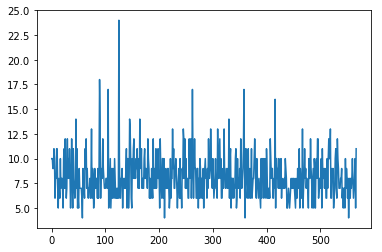

In [57]:
from skimage import measure

n_roi = []
for i in range(len(rgb_stack)):
    _, n = measure.label(predictions_ft[i].numpy() > 0.5, connectivity=1, return_num=True)
    n_roi.append(n)

plt.figure()
plt.plot(n_roi)
plt.show()

## Test drawing for manual annotations
Test drawing by mouse.

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from utils_finetuning import ROISelector
%load_ext autoreload
%autoreload 2

img = io.imread("/data/talabot/experiments/annotated/R70H06_20181202-tdTomGC6fopt-fl2/"
                "R70H06-tdTomGC6fopt-fly2-001/rgb_frames/rgb_0000.png")
imgs = np.stack([img] * 2)

roi_selector = ROISelector(img)

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(roi_selector.segmentation[0], cmap="gray")
plt.tight_layout()
plt.show()